In [1]:
import json
import warnings
import numpy as np
import pandas as pd
import chainer
import chainer.links as L
import chainer.functions as F
from chainer import training
from chainer.training import extensions

In [2]:
data_path = 'wine_class.csv'
df = pd.read_csv(data_path)

In [3]:
t = df.iloc[:, 0]
x = df.iloc[:, 1:]

In [4]:
t = t.values - 1
x = x.values

In [5]:
x = x.astype('float32')
t = t.astype('int32')

In [6]:
dataset = list(zip(x, t))

In [7]:
n_train = int(len(dataset) * 0.7)

# 訓練データ(train)と検証データ(test)に分割
train, test = chainer.datasets.split_dataset_random(dataset, n_train, seed=1)

In [8]:
n_train = int(len(train) * 0.7)

train, val = chainer.datasets.split_dataset_random(train, n_train,seed = 1)

In [9]:
class NN(chainer.Chain):

    # モデルの構造
    def __init__(self, n_mid_units=5, n_out=3):
        super(NN ,self).__init__()
        with self.init_scope():
            self.fc1 = L.Linear(None, n_mid_units)
            self.fc2 = L.Linear(None, n_out)
            self.bn = L.BatchNormalization(10)  # Batch Normalizationは平均と分散がパラメータ

    # 順伝播
    def __call__(self, x):
        h = self.bn(x)  # Batch Normalizationの処理を追加
        h = self.fc1(h)
        h = F.relu(h)
        h = self.fc2(h)
        return h
    
# 乱数のシードを固定
np.random.seed(1)

# モデルのインスタンス化
nn = NN()
model = L.Classifier(nn)

# Optimizerの定義
optimizer = chainer.optimizers.SGD()
optimizer.setup(model)  # modelと紐付ける

# Iteratorの定義
batchsize = 10
train_iter = chainer.iterators.SerialIterator(train, batchsize)
test_iter = chainer.iterators.SerialIterator(test, batchsize, repeat=False, shuffle=False)

# Updaterの定義
updater = chainer.training.StandardUpdater(train_iter, optimizer, device=-1)

# trainerとそのextensionsの設定
epoch = 50
trainer = training.Trainer(updater, (epoch, 'epoch'), out='result/wine')
trainer.extend(extensions.Evaluator(test_iter, model, device=-1))
trainer.extend(extensions.LogReport(trigger=(1, 'epoch')))
trainer.extend(extensions.PrintReport(['epoch', 'main/accuracy', 'validation/main/accuracy', 'main/loss', 'validation/main/loss', 'elapsed_time']), trigger=(1, 'epoch'))

In [10]:
trainer.run()

epoch       main/accuracy  validation/main/accuracy  main/loss   validation/main/loss  elapsed_time
1           0.388889       0.333333                  1.05478     2.08857               0.0330188     
2           0.488889       0.366667                  1.03452     1.17053               0.0622402     
3           0.5            0.4                       1.01345     1.00288               0.0913516     
4           0.6            0.541667                  0.986239    0.959816              0.120913      
5           0.6            0.55                      0.968737    0.948747              0.14982       
6           0.711111       0.566667                  0.933829    0.936281              0.179441      
7           0.777778       0.583333                  0.883878    0.919                 0.21054       
8           0.7625         0.6                       0.876588    0.903385              0.234994      
9           0.844444       0.616667                  0.851275    0.88314            

In [11]:
# logファイルから結果の読み込み
with open('result/wine/log') as f:
    logs = json.load(f)
    results = pd.DataFrame(logs)

<AxesSubplot:>

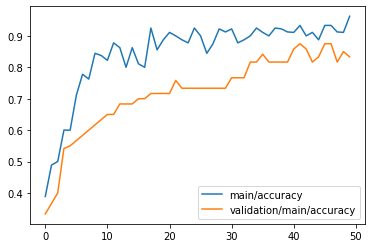

In [12]:
# accuracy（精度）を表示
%matplotlib inline
results[['main/accuracy', 'validation/main/accuracy']].plot()

<AxesSubplot:>

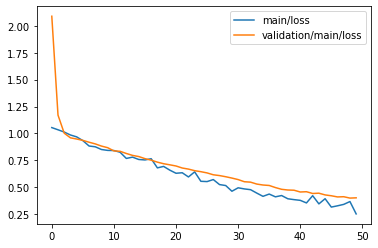

In [13]:
# loss（損失関数）を表示
results[['main/loss', 'validation/main/loss']].plot()

In [14]:
test_evaluator = extensions.Evaluator(test_iter, model)
results = test_evaluator()
print('Test accuracy:', results['main/accuracy'])

Test accuracy: 0.8333333134651184
